<a href="https://colab.research.google.com/github/Carlos-39/Talleres-RN/blob/main/Taller2_RedesNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Taller 2 - Redes Neuronales

##Integrantes:
- Carlos Daniel Corrales Arango (2122878)
- Jose Manuel Palma (2125182)

### Contenido del Notebook:


# Base del taller

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [ ]:
class vanillaRNN:
    def __init__(self, n_x, n_h, seq_length, learning_rate):
        # hyperparameters
        self.n_x = n_x
        self.n_h = n_h
        self.seq_length = seq_length
        self.learning_rate = learning_rate

        # initialize model parameters
        self.Wxh = np.random.randn(n_h, n_x) * 0.01
        self.Whh = np.random.randn(n_h, n_h) * 0.01
        self.Why = np.random.randn(n_x, n_h) * 0.01
        self.bh = np.zeros((n_h, 1))
        self.by = np.zeros((n_x, 1))

        # memory vars for adagrad
        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh)
        self.mWhy = np.zeros_like(self.Why)
        self.mbh = np.zeros_like(self.bh)
        self.mby = np.zeros_like(self.by)

    def forward_pass(self, inputs, targets, hprev):
        """
        inputs -- list of integers (tokenizer: char to int)
        targets -- list of integers (tokenizer: char to int)
        hprev -- the initial hidden state
        """
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(hprev)
        loss = 0

        for t in range(len(inputs)):

            # one hot encoder of a char
            x[t] = np.zeros((self.n_x, 1))
            x[t][inputs[t]] = 1
            h[t] = np.tanh(self.Wxh @ x[t] + self.Whh @ h[t-1] + self.bh)
            y[t] = self.Why @ h[t] + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
            loss = loss - np.log(p[t][targets[t], 0])

        return loss, x, h, p

    def backpropagation(self, x, h, p, targets):

        dWxh, dWhy, dWhh = np.zeros_like(self.Wxh), np.zeros_like(self.Why), np.zeros_like(self.Whh)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h[0])

        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] =  dy[targets[t]] - 1
            dWhy = dWhy + dy @ h[t].T
            dby = dby + dy
            dh = self.Why.T @ dy + dhnext
            dhraw = (1 - h[t] * h[t]) * dh
            dbh = dbh + dhraw
            dWxh = dWxh + dhraw @ x[t].T
            dWhh = dWhh + dhraw @ h[t-1].T
            dhnext = self.Whh.T @ dhraw
        for dpara in [dWxh, dWhh, dWhy, dby, dbh]:
            np.clip(dpara, -5, 5, out = dpara)

        return dWxh, dWhh, dWhy, dbh, dby

    def update_para(self, dWxh, dWhh, dWhy, dbh, dby):
        for para, dpara, mem in zip(['Wxh', 'Whh', 'Why', 'bh', 'by'],
                                    [dWxh, dWhh, dWhy, dbh, dby],
                                    ['mWxh', 'mWhh', 'mWhy', 'mbh', 'mby']):

            setattr(self, mem, getattr(self, mem) + dpara * dpara)
            setattr(self, para, getattr(self, para) - self.learning_rate * dpara/np.sqrt(getattr(self, mem) + 1e-8))

    def train(self, inputs, char_to_int, int_to_char, max_iter = 1e4):

        iter_num, position = 0, 0
        loss_list = []
        loss_list.append(- np.log(1 / self.n_x) * self.seq_length)

        while iter_num <= max_iter:
            if iter_num%1000 ==0: print(iter_num)
            ## reset the rnn after an epoch
            if position + self.seq_length + 1 >= len(inputs) or iter_num == 0:
                hprev = np.zeros((self.n_h, 1))
                position = 0

            ## chars to int
            input_bacth = [char_to_int[ch] for ch in inputs[position:position + self.seq_length]]
            target_bacth = [char_to_int[ch] for ch in inputs[position + 1 : position + self.seq_length + 1]]
            position = position + self.seq_length
            ## forward_pass
            loss, x, h, p = self.forward_pass(input_bacth, target_bacth, hprev)
            loss_list.append(loss_list[-1] * 0.999 + loss * 0.001)
            ## backpropagation
            dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p, target_bacth)
            ## adagrad upate
            self.update_para(dWxh, dWhh, dWhy, dbh, dby)
            hprev = h[self.seq_length - 1]

            iter_num = iter_num + 1

        ## make a sample after training
        sample_ix = self.make_sample(hprev, target_bacth[-1], 200)
        sample_char = ''.join(int_to_char[ix] for ix in sample_ix)

        return loss_list, sample_char


    def make_sample(self, hprev, seed_ix, n):
        """
        sample a length n sequence from the model
        """
        x = np.zeros((self.n_x, 1))
        x[seed_ix] = 1
        ixes = []
        h = np.copy(hprev)

        for t in range(n):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            y = self.Why @ h + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.n_x), p = p.ravel())
            x = np.zeros((self.n_x, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes

In [ ]:
with open('input.txt') as f:
    words = f.read()
    chars = list(set(words))
    words_size, vocab_size = len(words), len(chars)
    char_to_int = {ch:i for i, ch in enumerate(chars)}
    int_to_char = {i:ch for i, ch in enumerate(chars)}

rnn = vanillaRNN(n_x = vocab_size, n_h = 100, seq_length = 25, learning_rate = 1e-1)
loss_list, sample_char = rnn.train(words, char_to_int, int_to_char, max_iter = 50000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


In [ ]:
# Prueba de texto de salida
print(sample_char)

 hind you rot makan'l, you sun fouls thaige, your, forone word pry truef him when the sabuth.

MENUTUS:
I Ame oghan that me fand smastrry, a tonst?, have huinef'gh-nito's is fes sitkeare or which I me


# Punto 1

## Grafica de la función de pérdida vs iteraciones

Se agregó una funcionalidad para visualizar cómo evoluciona la pérdida a lo largo del entrenamiento del modelo RNN Vanilla. Esto permite observar la convergencia del algoritmo y evaluar su desempeño, se tomo ya de la clase principal los valores de loss_list que ya lo retorna por defecto.

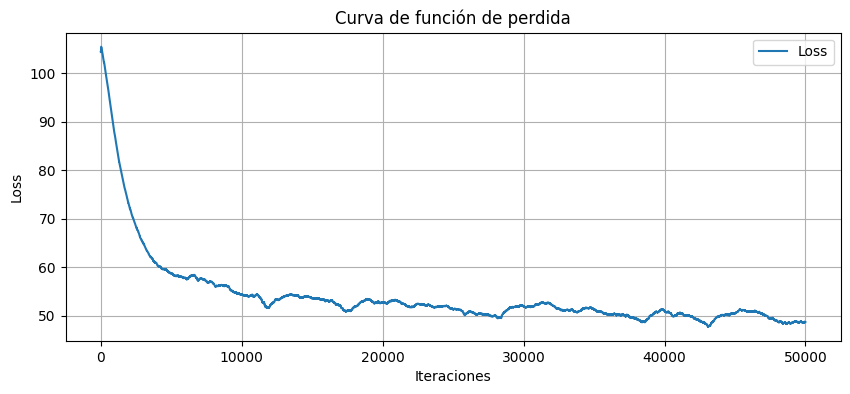

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(loss_list, label='Loss')
plt.xlabel('Iteraciones')
plt.ylabel('Loss')
plt.title('Curva de función de perdida')
plt.grid(True)
plt.legend()
plt.show()

## Modificación del método backpropagation para habilitar/deshabilitar el clipping de gradientes

Durante el entrenamiento de redes neuronales, especificamente las RNN, es común que los gradientes se vuelvan extremadamente grandes causando un exploding gradients, lo que puede llevar a una inestabilidad en el aprendizaje. Para suavizar este problema, se suele aplicar un clipping de gradientes, que limita los valores de los gradientes dentro de un rango definido (en este caso, entre -5 y 5).

### Modificación del código

In [ ]:
class vanillaRNN:
    def __init__(self, n_x, n_h, seq_length, learning_rate, gradient_clipping):
        # hyperparameters
        self.n_x = n_x
        self.n_h = n_h
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        self.gradient_clipping = gradient_clipping # Implementacion del gradient clipping

        # initialize model parameters
        self.Wxh = np.random.randn(n_h, n_x) * 0.01
        self.Whh = np.random.randn(n_h, n_h) * 0.01
        self.Why = np.random.randn(n_x, n_h) * 0.01
        self.bh = np.zeros((n_h, 1))
        self.by = np.zeros((n_x, 1))

        # memory vars for adagrad
        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh)
        self.mWhy = np.zeros_like(self.Why)
        self.mbh = np.zeros_like(self.bh)
        self.mby = np.zeros_like(self.by)

    def forward_pass(self, inputs, targets, hprev):
        """
        inputs -- list of integers (tokenizer: char to int)
        targets -- list of integers (tokenizer: char to int)
        hprev -- the initial hidden state
        """
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(hprev)
        loss = 0

        for t in range(len(inputs)):

            # one hot encoder of a char
            x[t] = np.zeros((self.n_x, 1))
            x[t][inputs[t]] = 1
            h[t] = np.tanh(self.Wxh @ x[t] + self.Whh @ h[t-1] + self.bh)
            y[t] = self.Why @ h[t] + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
            loss = loss - np.log(p[t][targets[t], 0])

        return loss, x, h, p

    def backpropagation(self, x, h, p, targets):

        dWxh, dWhy, dWhh = np.zeros_like(self.Wxh), np.zeros_like(self.Why), np.zeros_like(self.Whh)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h[0])

        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] =  dy[targets[t]] - 1
            dWhy = dWhy + dy @ h[t].T
            dby = dby + dy
            dh = self.Why.T @ dy + dhnext
            dhraw = (1 - h[t] * h[t]) * dh
            dbh = dbh + dhraw
            dWxh = dWxh + dhraw @ x[t].T
            dWhh = dWhh + dhraw @ h[t-1].T
            dhnext = self.Whh.T @ dhraw

        if self.gradient_clipping: # activacion del gradient clipping
          for dpara in [dWxh, dWhh, dWhy, dby, dbh]:
              np.clip(dpara, -5, 5, out = dpara)

        return dWxh, dWhh, dWhy, dbh, dby

    def update_para(self, dWxh, dWhh, dWhy, dbh, dby):
        for para, dpara, mem in zip(['Wxh', 'Whh', 'Why', 'bh', 'by'],
                                    [dWxh, dWhh, dWhy, dbh, dby],
                                    ['mWxh', 'mWhh', 'mWhy', 'mbh', 'mby']):

            setattr(self, mem, getattr(self, mem) + dpara * dpara)
            setattr(self, para, getattr(self, para) - self.learning_rate * dpara/np.sqrt(getattr(self, mem) + 1e-8))

    def train(self, inputs, char_to_int, int_to_char, max_iter = 1e4):

        iter_num, position = 0, 0
        loss_list = []
        loss_list.append(- np.log(1 / self.n_x) * self.seq_length)

        while iter_num <= max_iter:
            if iter_num%1000 ==0: print(iter_num)
            ## reset the rnn after an epoch
            if position + self.seq_length + 1 >= len(inputs) or iter_num == 0:
                hprev = np.zeros((self.n_h, 1))
                position = 0

            ## chars to int
            input_bacth = [char_to_int[ch] for ch in inputs[position:position + self.seq_length]]
            target_bacth = [char_to_int[ch] for ch in inputs[position + 1 : position + self.seq_length + 1]]
            position = position + self.seq_length
            ## forward_pass
            loss, x, h, p = self.forward_pass(input_bacth, target_bacth, hprev)
            loss_list.append(loss_list[-1] * 0.999 + loss * 0.001)
            ## backpropagation
            dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p, target_bacth)
            ## adagrad upate
            self.update_para(dWxh, dWhh, dWhy, dbh, dby)
            hprev = h[self.seq_length - 1]

            iter_num = iter_num + 1

        ## make a sample after training
        sample_ix = self.make_sample(hprev, target_bacth[-1], 200)
        sample_char = ''.join(int_to_char[ix] for ix in sample_ix)

        return loss_list, sample_char


    def make_sample(self, hprev, seed_ix, n):
        """
        sample a length n sequence from the model
        """
        x = np.zeros((self.n_x, 1))
        x[seed_ix] = 1
        ixes = []
        h = np.copy(hprev)

        for t in range(n):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            y = self.Why @ h + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.n_x), p = p.ravel())
            x = np.zeros((self.n_x, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes

### Pruebas

In [ ]:
# Entrenamiento de la red aplicando el gradient clipping
rnn_with_clipping = vanillaRNN(n_x = vocab_size, n_h = 100, seq_length = 25, learning_rate = 1e-1, gradient_clipping=True)
loss_list_clip, sample_char = rnn.train(words, char_to_int, int_to_char, max_iter = 50000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


In [ ]:
# Prueba de texto de salida
print(sample_char)

'lles erofear my orecines you have boon;
Hes you down whis hes, were he amench prave is soot hut presernor, rement
It 'ting,
name his an sureicugine.,
ae't, youe the Ascaje and dig
-oname our for spoo


In [ ]:
# Entrenamiento de la red desactivando el gradient clipping
rnn_with_noClipping = vanillaRNN(n_x = vocab_size, n_h = 100, seq_length = 25, learning_rate = 1e-1, gradient_clipping=False)
loss_list_noClip, sample_char = rnn.train(words, char_to_int, int_to_char, max_iter = 50000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


In [ ]:
# Prueba de texto de salida
print(sample_char)

 gemid that doon them sharlut and hone feefss peverot, wime than, of yeerd so thangeld fore? affscind, wime e'st must
Yo? for
Coluse, the bothon.
That with you elot, and for of me weul onews.

SICINIU


### Comparación de entrenamiento aplicando el gradient clipping vs entrenamiento sin aplicar gradient clipping

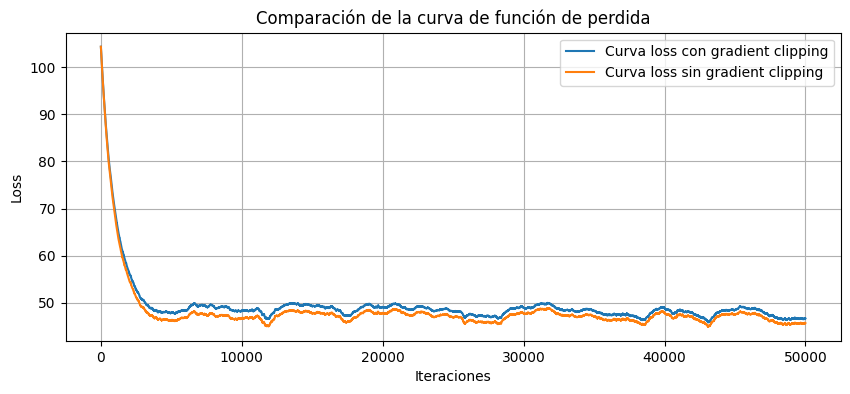

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(loss_list_clip, label='Curva loss con gradient clipping')
plt.plot(loss_list_noClip, label='Curva loss sin gradient clipping')
plt.xlabel('Iteraciones')
plt.ylabel('Loss')
plt.title('Comparación de la curva de función de perdida')
plt.grid(True)
plt.legend()
plt.show()

### Analisís

Las diferencias entre ambas curvas son muy leves, lo cual puede decir que en este caso en particular el uso de clipping no tuvo un impacto significativo en el desempeño del modelo.
- Quizas en secuencias mas largas o entrenamiento más profundo, el cplipping si tendría una importancia significativa en el proceso de entrenamiento.
- Al no existir una gran diferencia entre ambos entrenamientos, se podría decir que es una buena practica aplicar el clipping del gradiente para prevenir gradientes explosivos y mas estabilidad en el entrenamiento.

# Punto 2

Se toma como referencia el dataset female.txt disponibles en https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/

### Entrenamiento de la RNN usando diferentes valores

Esos valores por los cuales se va a probar la red en cada caso son:

- seq_lengths = [10, 25, 50]
- data_sizes = [5000, 15000, 35000]
- max_iters = [10000, 25000, 50000]
- gradient_clipping = [True, False]

In [ ]:
seq_lengths = [10, 25, 50]
data_sizes = [5000, 15000, 35000]
max_iters = [10000, 25000, 50000]
gradient_clippings = [True, False]

In [ ]:
# Cargar los datos
with open('female.txt') as f:
    words = f.read()
    chars = list(set(words))
    words_size, vocab_size = len(words), len(chars)
    char_to_int = {ch:i for i, ch in enumerate(chars)}
    int_to_char = {i:ch for i, ch in enumerate(chars)}

Ejecutar posibles combinaciones


 Caso #1: seq=10, data=5000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


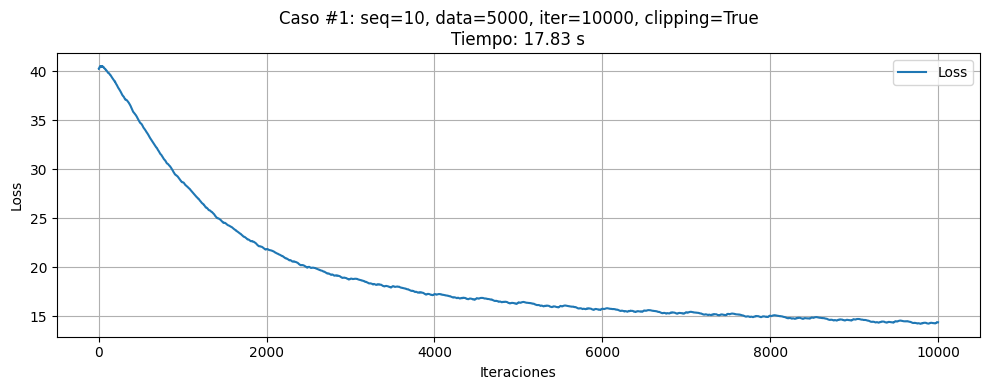


 Caso #2: seq=10, data=5000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


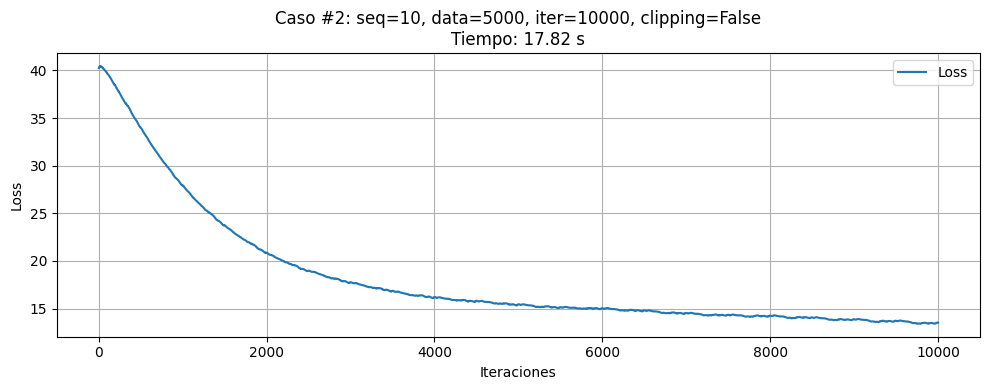


 Caso #3: seq=10, data=5000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


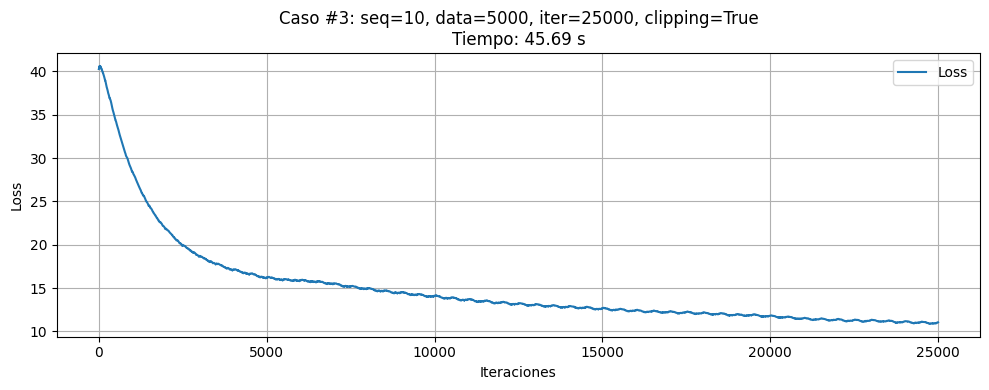


 Caso #4: seq=10, data=5000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


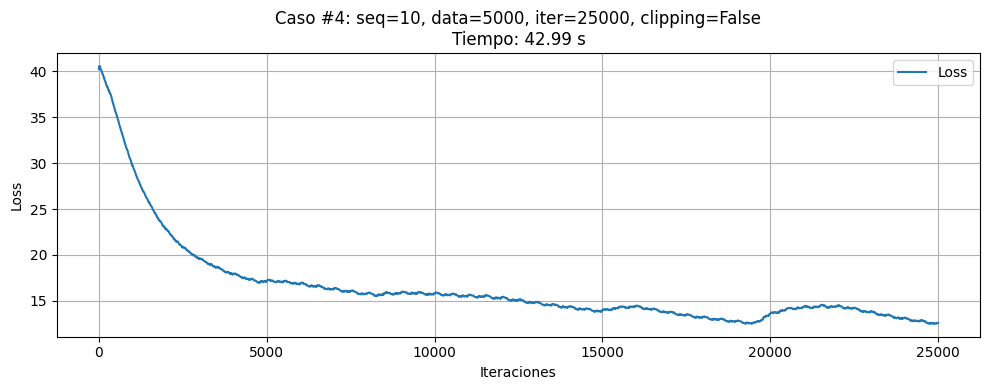


 Caso #5: seq=10, data=5000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


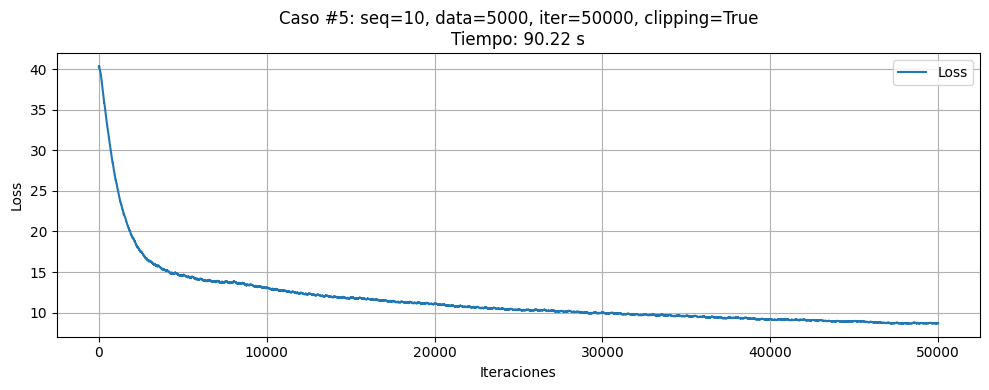


 Caso #6: seq=10, data=5000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


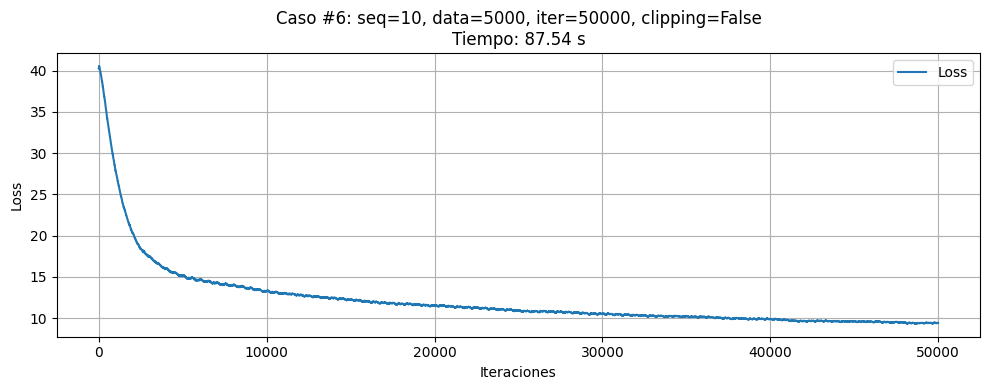


 Caso #7: seq=10, data=15000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


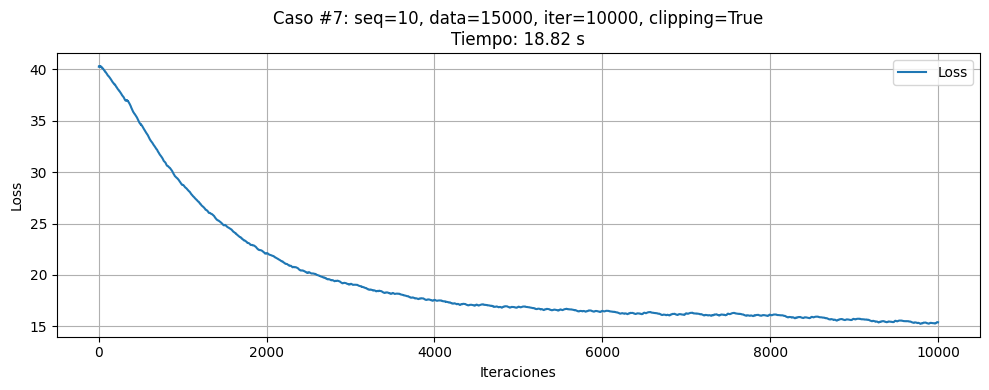


 Caso #8: seq=10, data=15000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


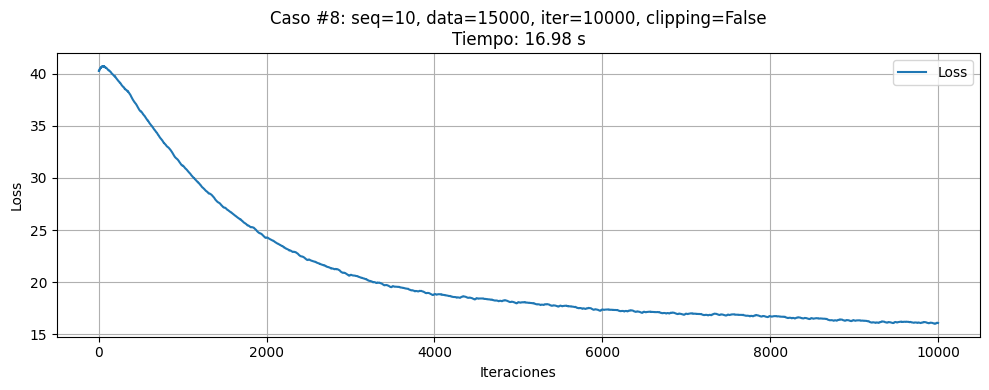


 Caso #9: seq=10, data=15000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


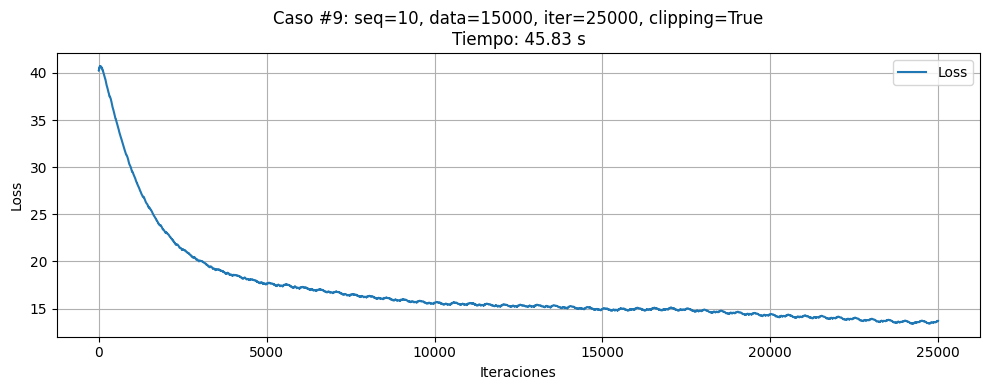


 Caso #10: seq=10, data=15000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


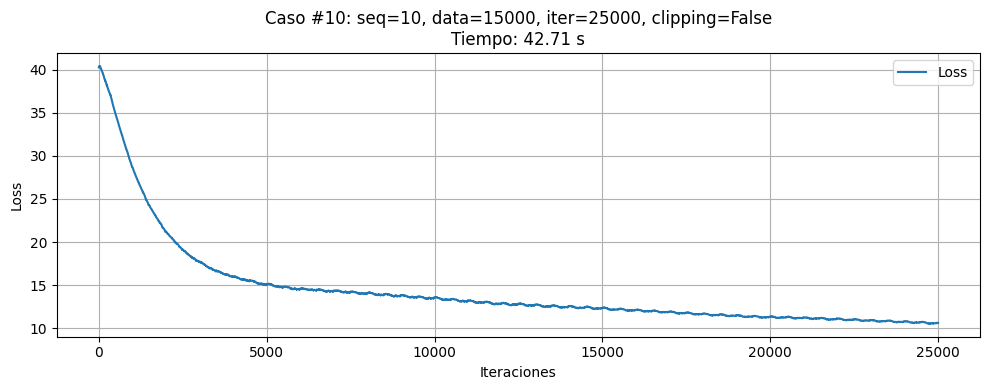


 Caso #11: seq=10, data=15000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


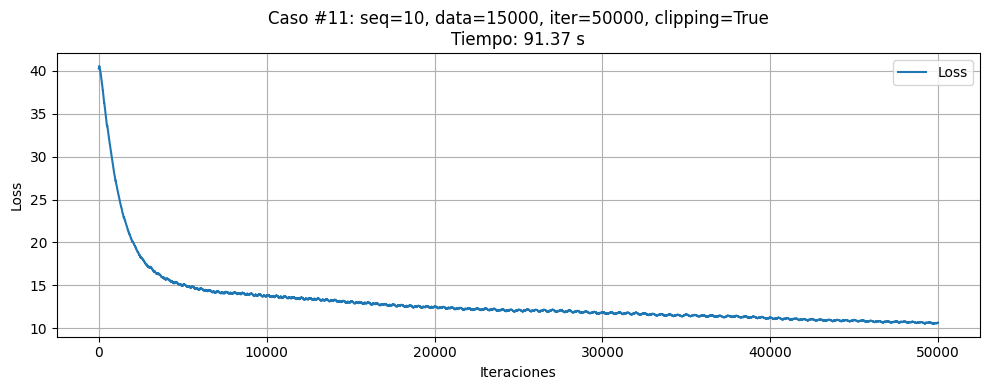


 Caso #12: seq=10, data=15000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


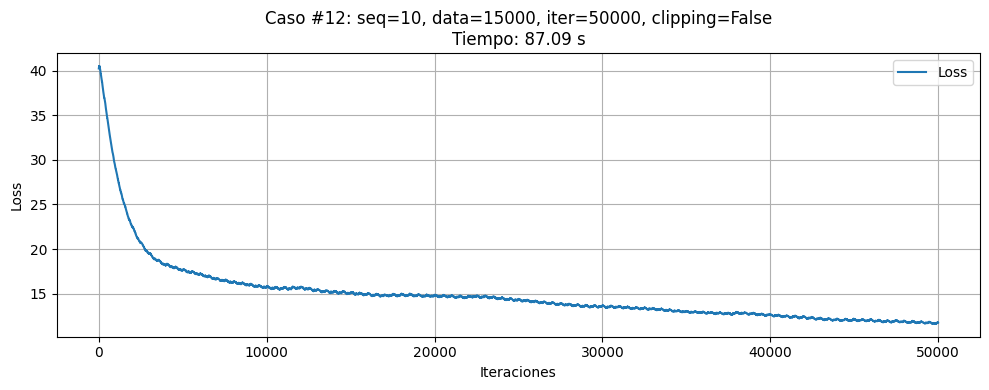


 Caso #13: seq=10, data=35000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


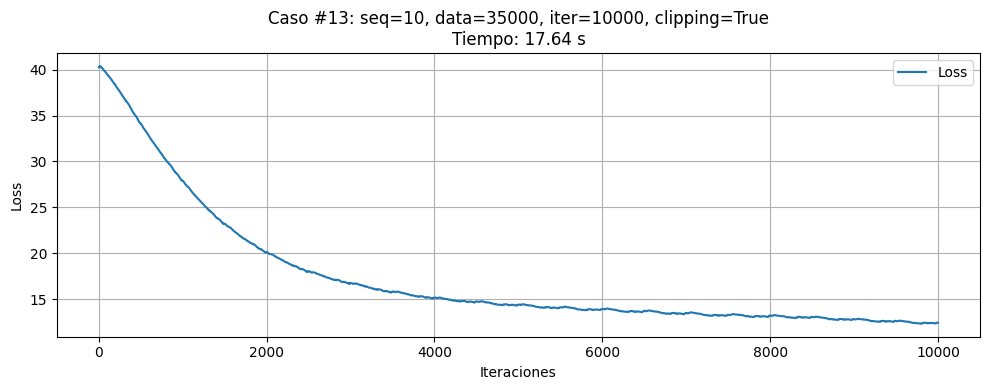


 Caso #14: seq=10, data=35000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


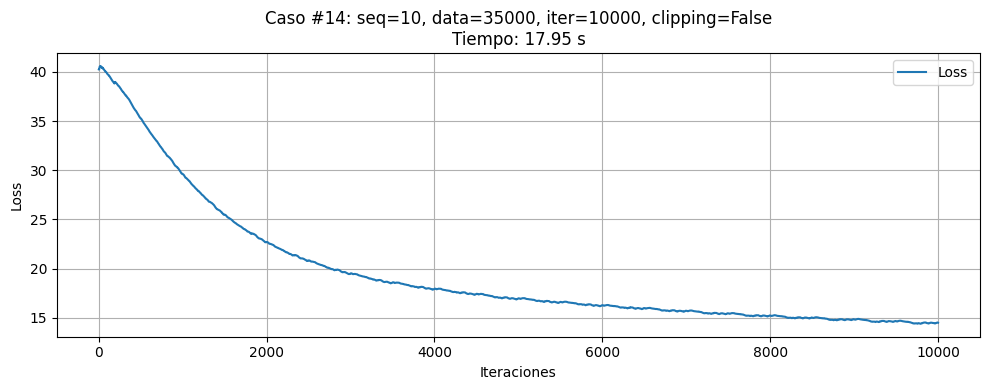


 Caso #15: seq=10, data=35000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


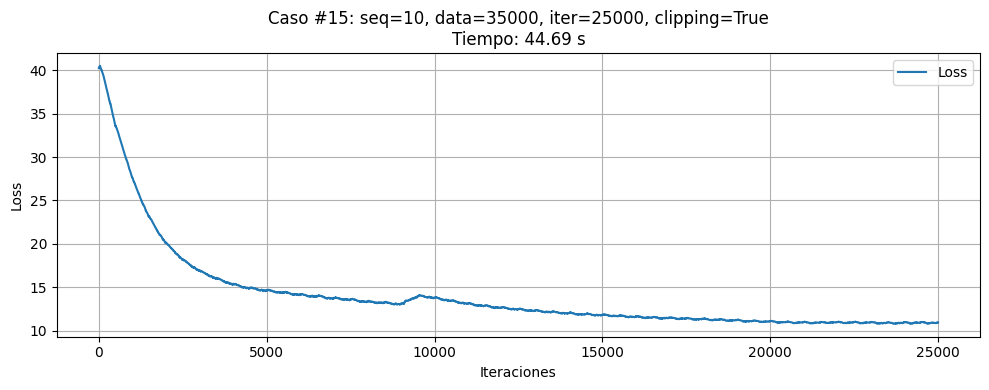


 Caso #16: seq=10, data=35000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


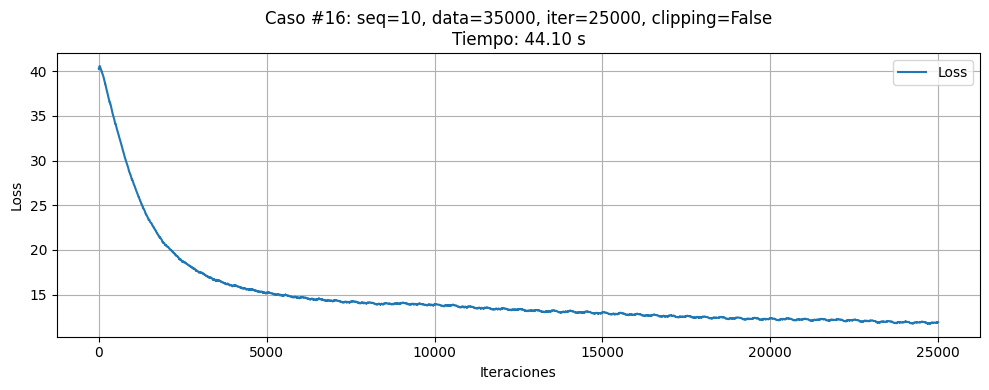


 Caso #17: seq=10, data=35000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


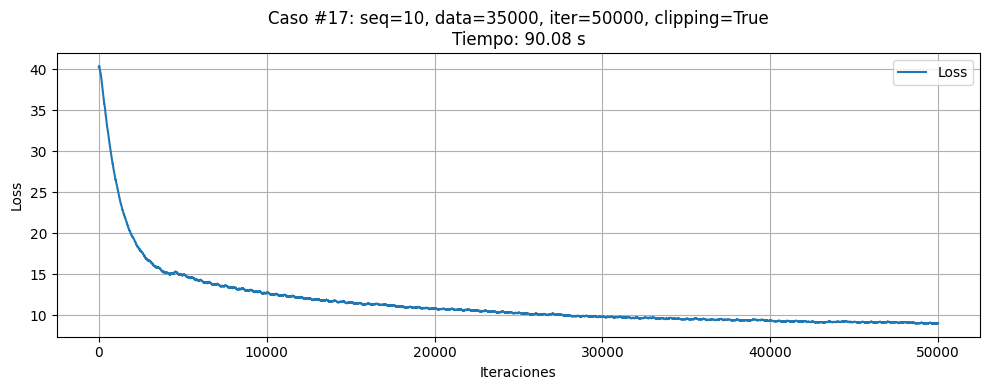


 Caso #18: seq=10, data=35000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


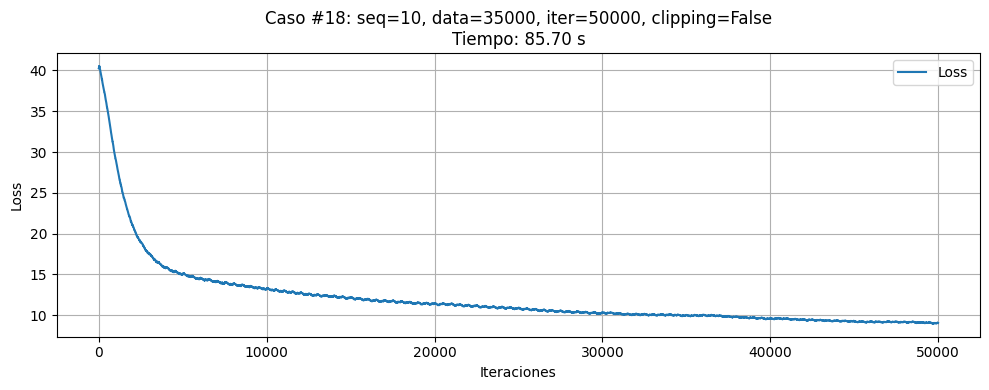


 Caso #19: seq=25, data=5000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


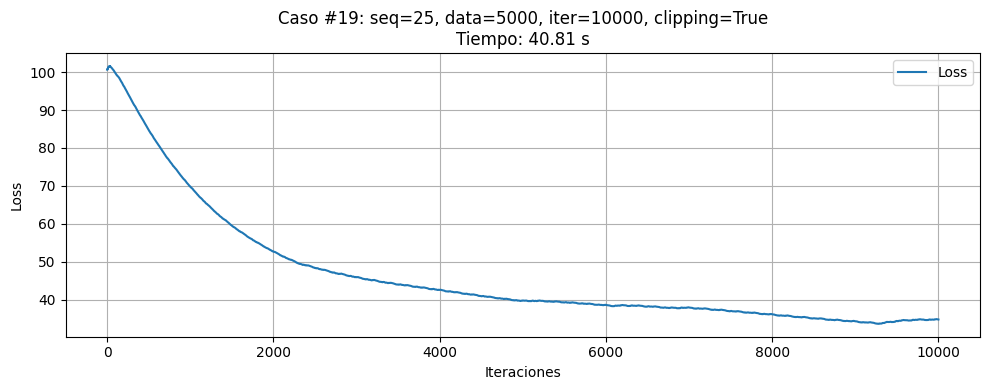


 Caso #20: seq=25, data=5000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


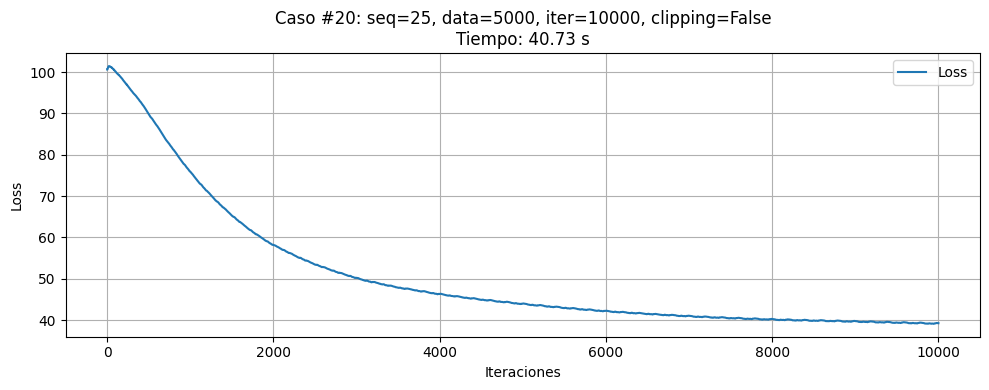


 Caso #21: seq=25, data=5000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


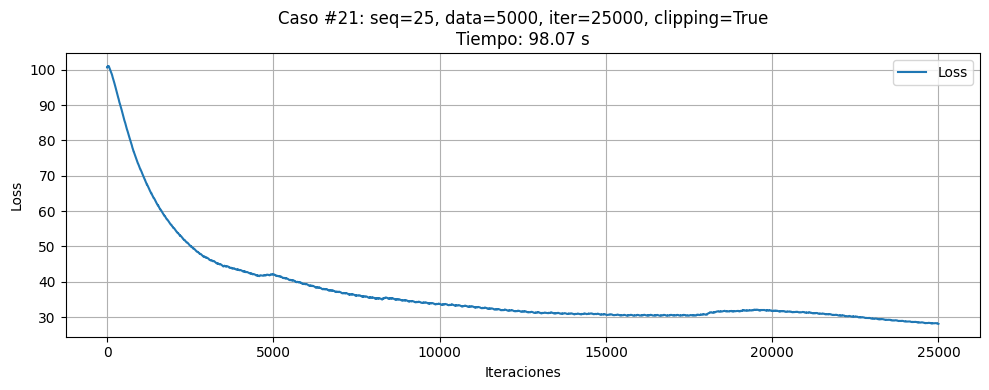


 Caso #22: seq=25, data=5000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


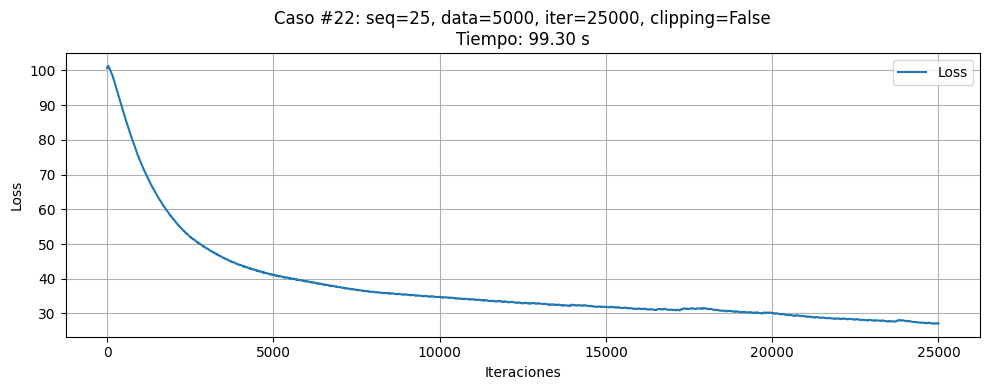


 Caso #23: seq=25, data=5000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


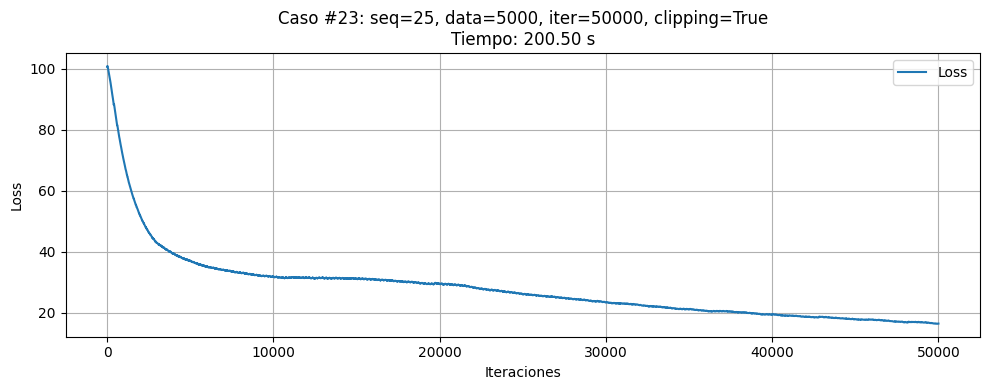


 Caso #24: seq=25, data=5000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


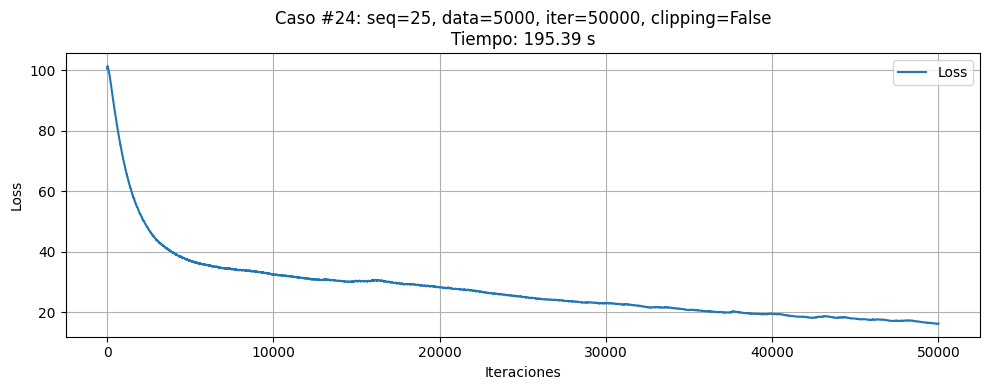


 Caso #25: seq=25, data=15000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


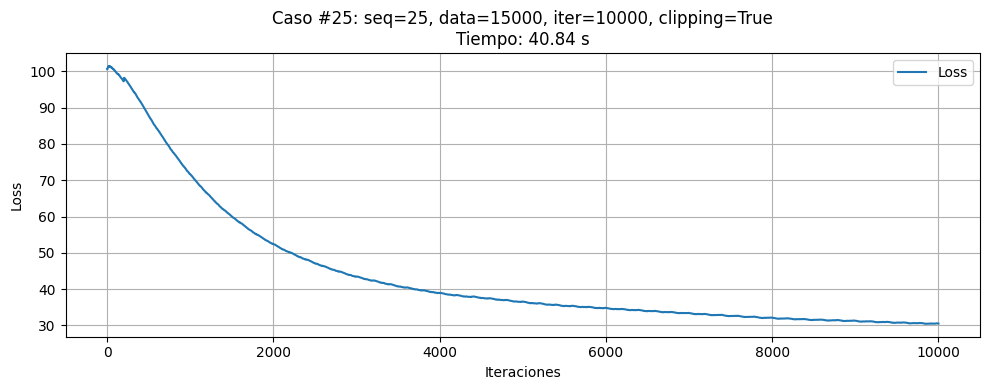


 Caso #26: seq=25, data=15000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


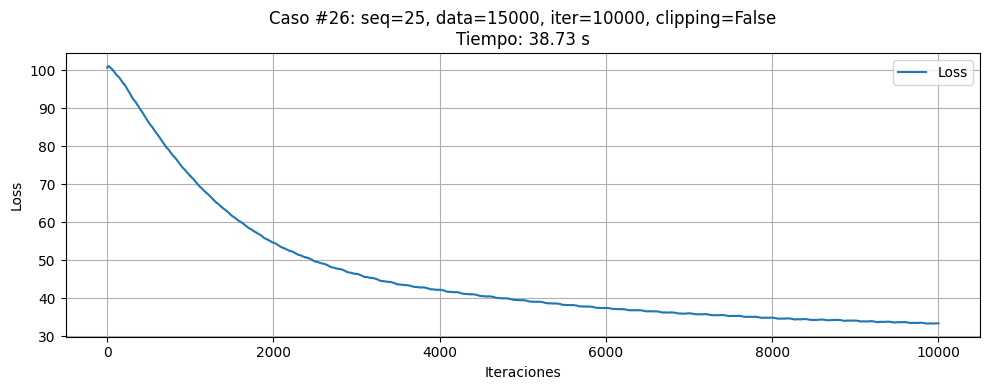


 Caso #27: seq=25, data=15000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


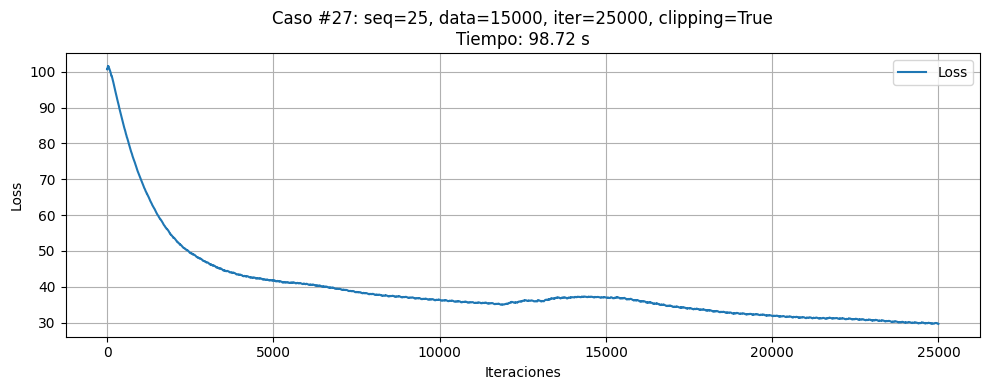


 Caso #28: seq=25, data=15000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


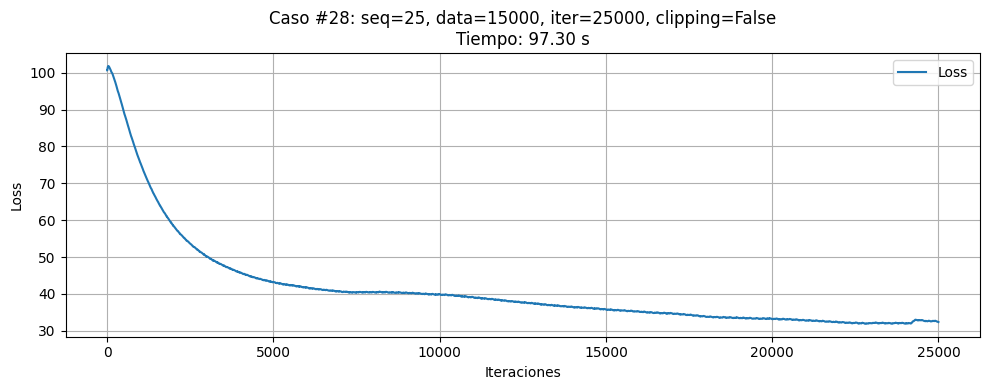


 Caso #29: seq=25, data=15000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


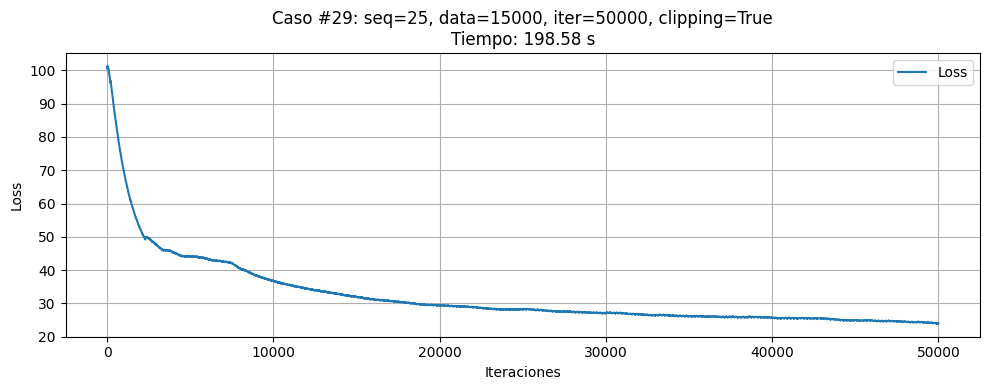


 Caso #30: seq=25, data=15000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


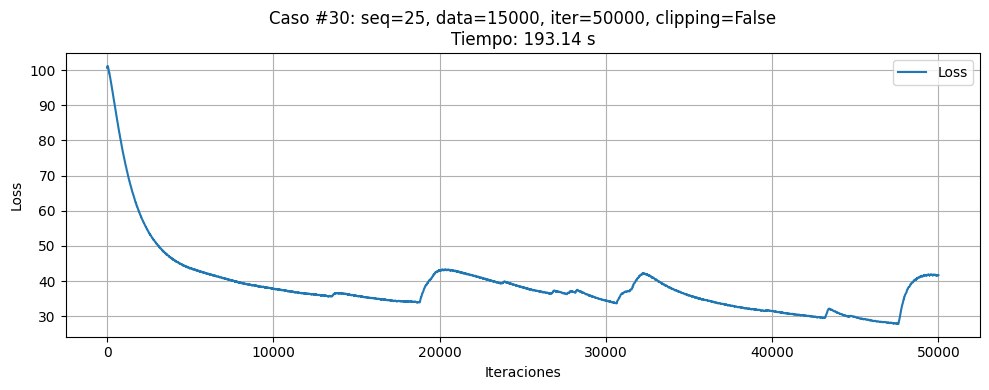


 Caso #31: seq=25, data=35000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


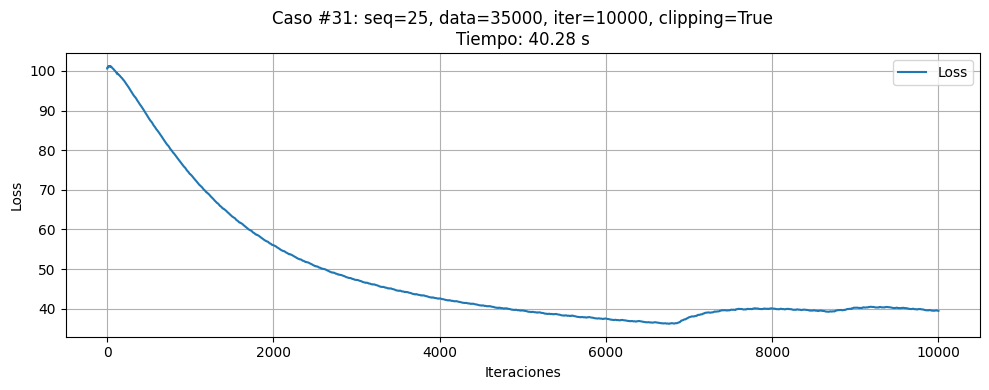


 Caso #32: seq=25, data=35000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


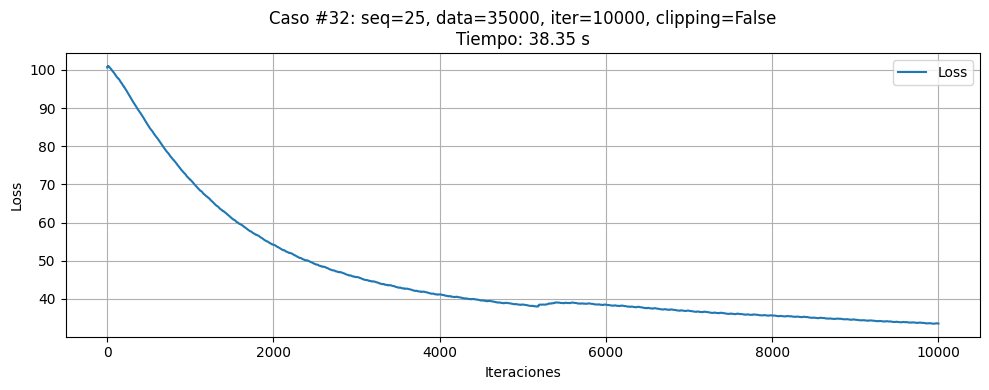


 Caso #33: seq=25, data=35000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


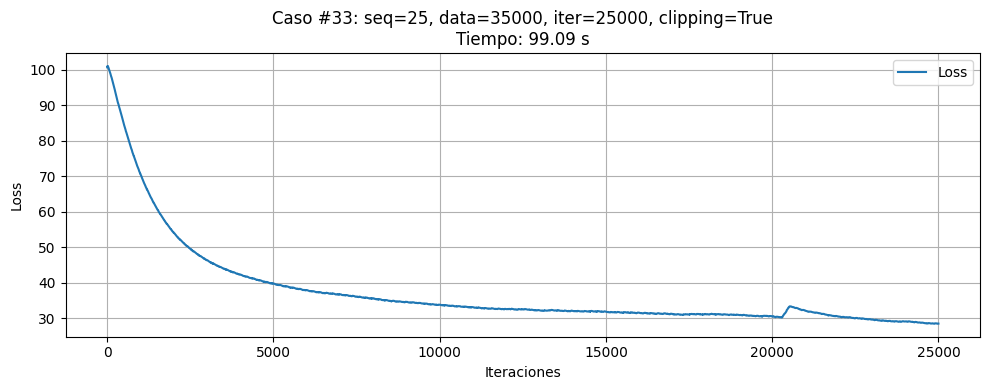


 Caso #34: seq=25, data=35000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


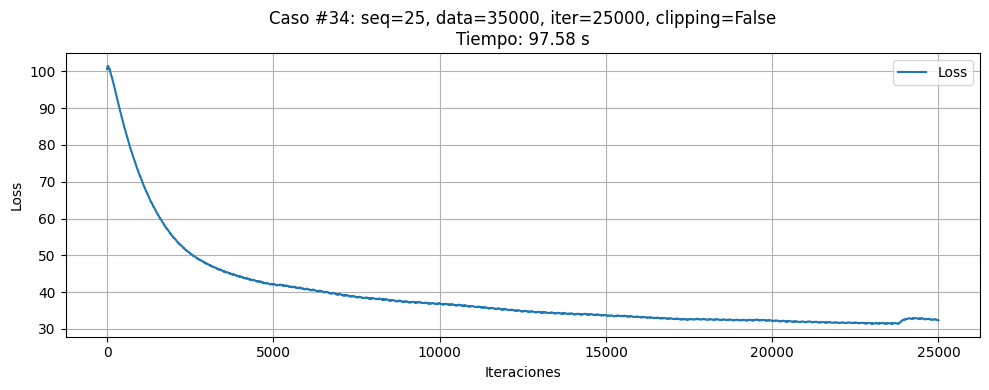


 Caso #35: seq=25, data=35000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


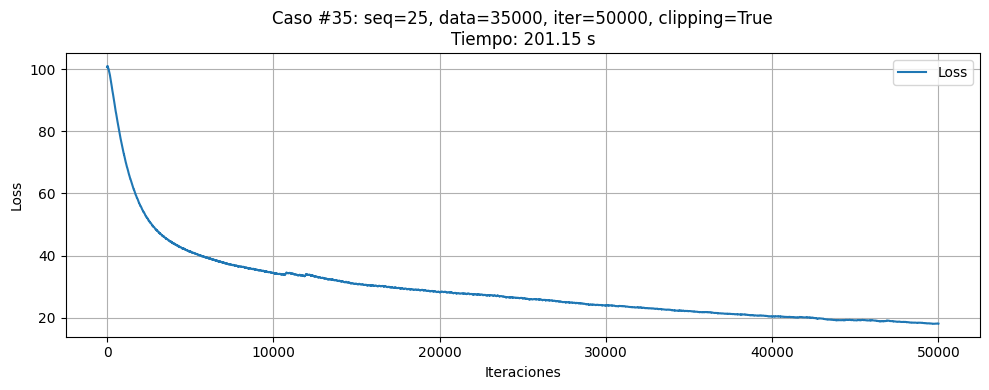


 Caso #36: seq=25, data=35000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


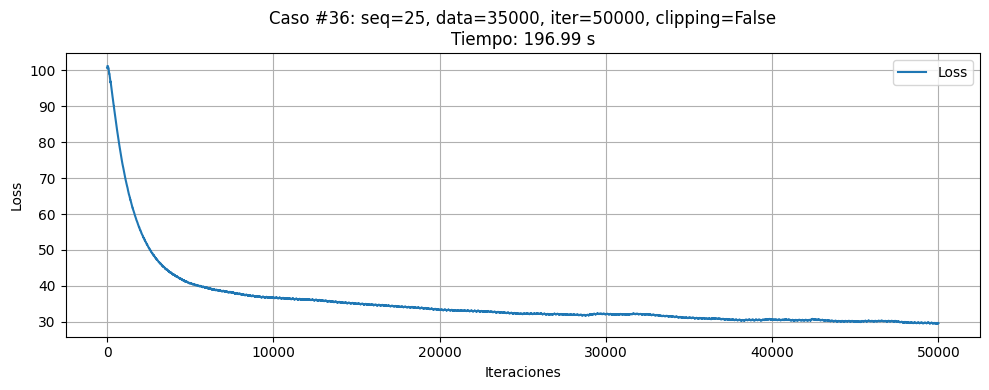


 Caso #37: seq=50, data=5000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


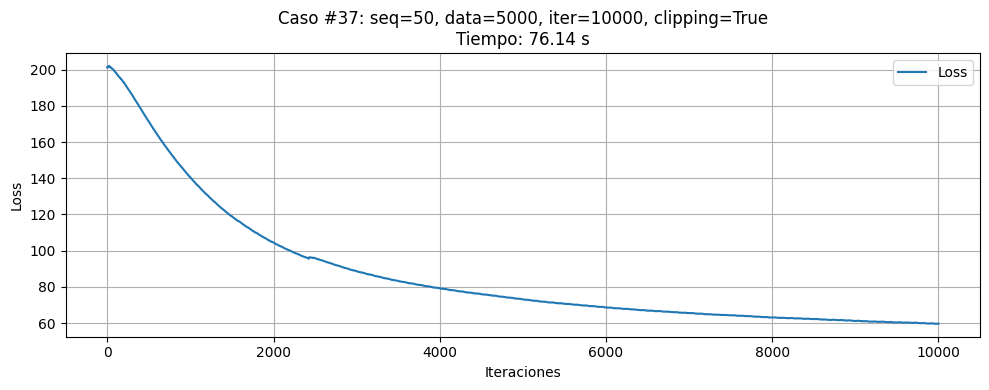


 Caso #38: seq=50, data=5000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


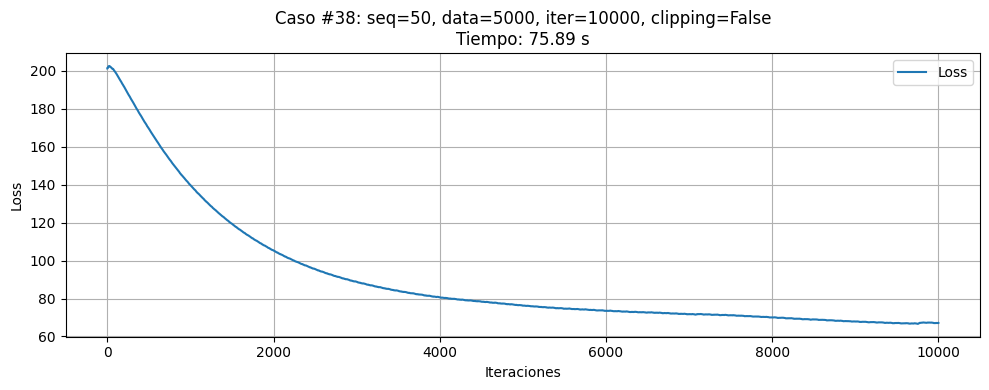


 Caso #39: seq=50, data=5000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


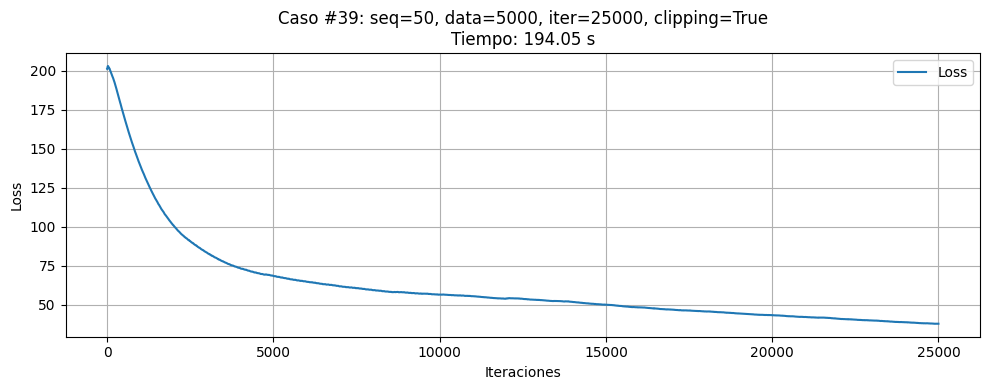


 Caso #40: seq=50, data=5000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


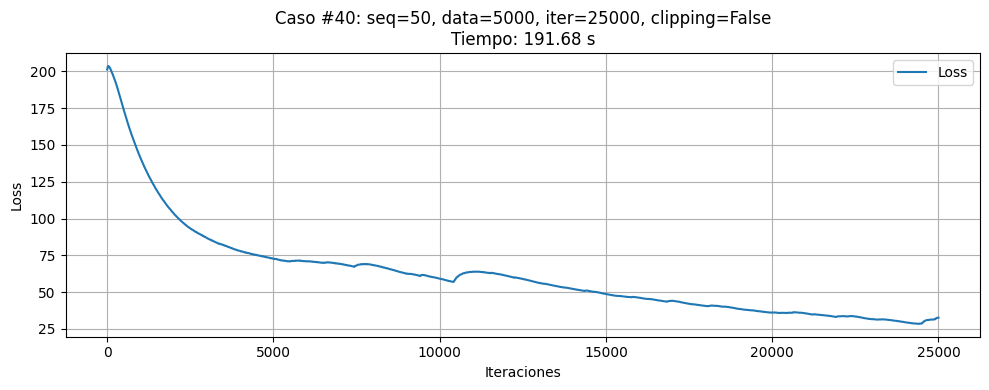


 Caso #41: seq=50, data=5000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


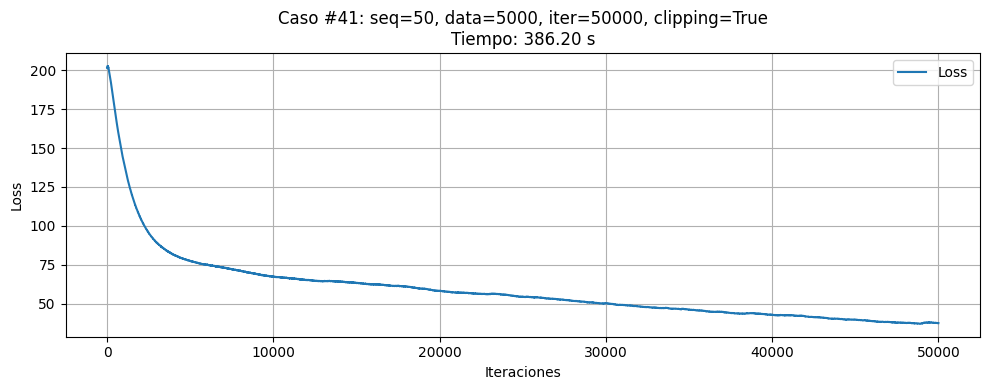


 Caso #42: seq=50, data=5000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


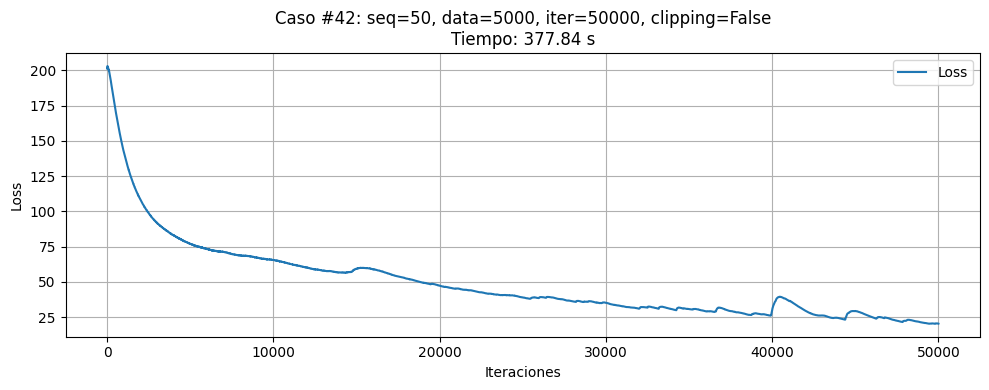


 Caso #43: seq=50, data=15000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


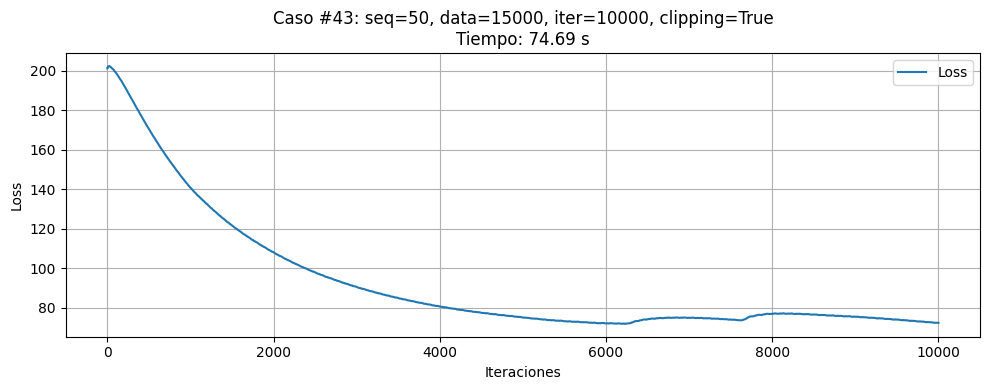


 Caso #44: seq=50, data=15000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


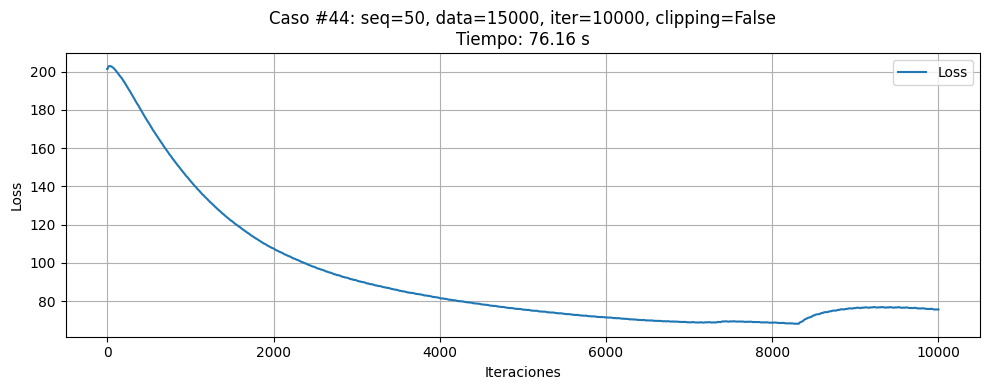


 Caso #45: seq=50, data=15000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


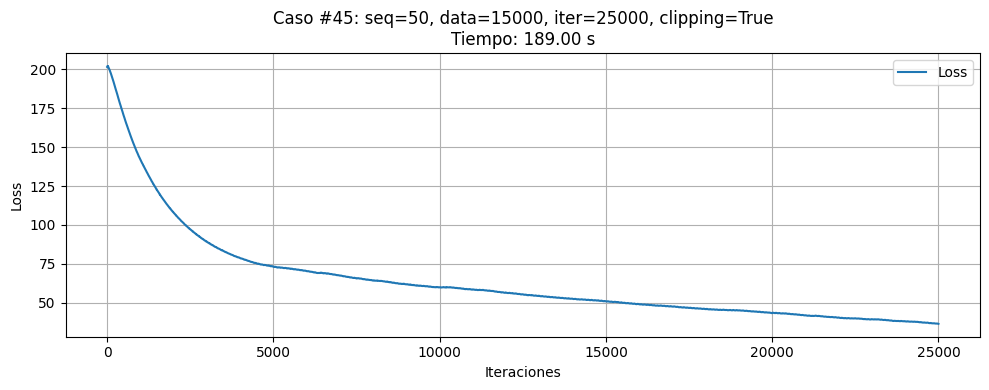


 Caso #46: seq=50, data=15000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


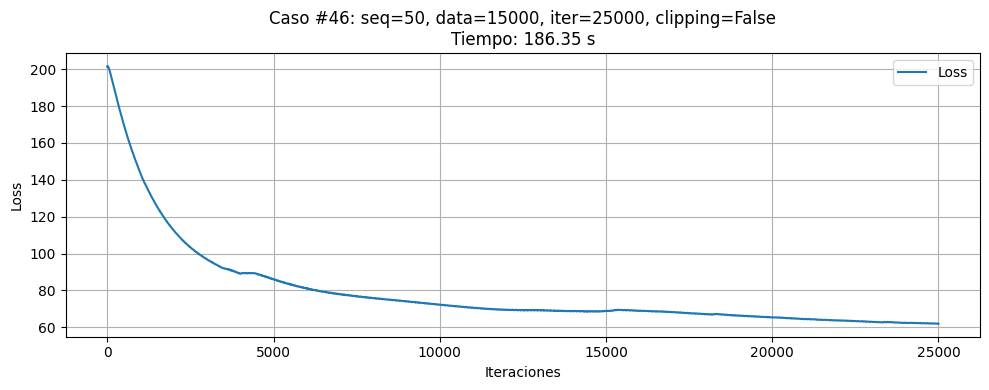


 Caso #47: seq=50, data=15000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


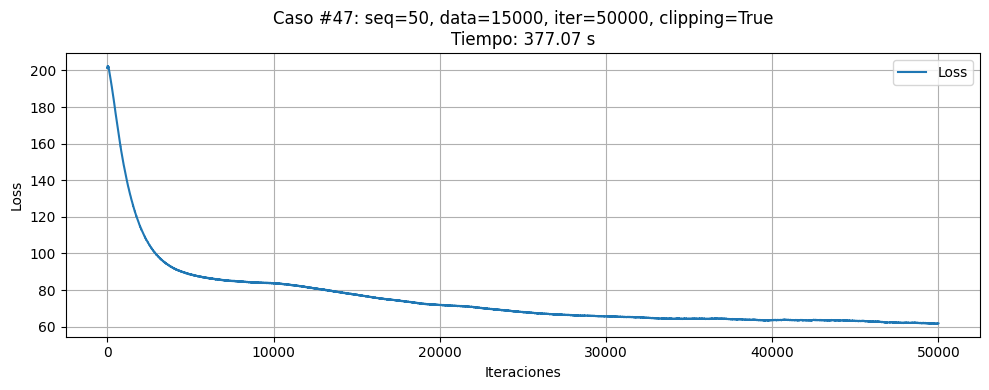


 Caso #48: seq=50, data=15000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


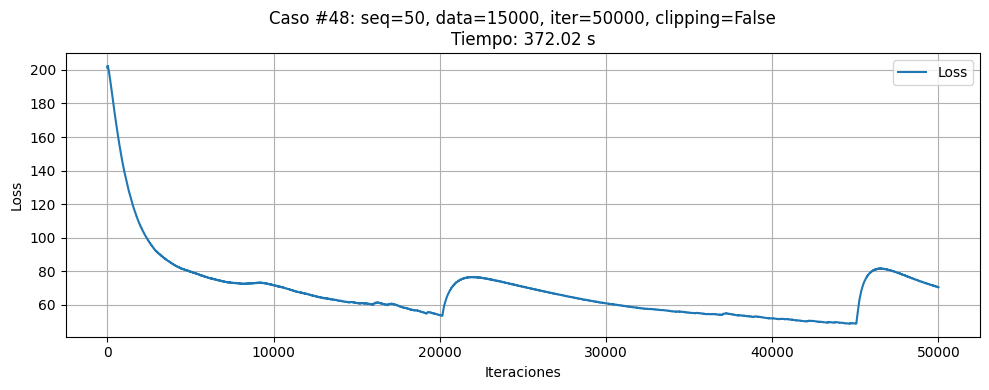


 Caso #49: seq=50, data=35000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


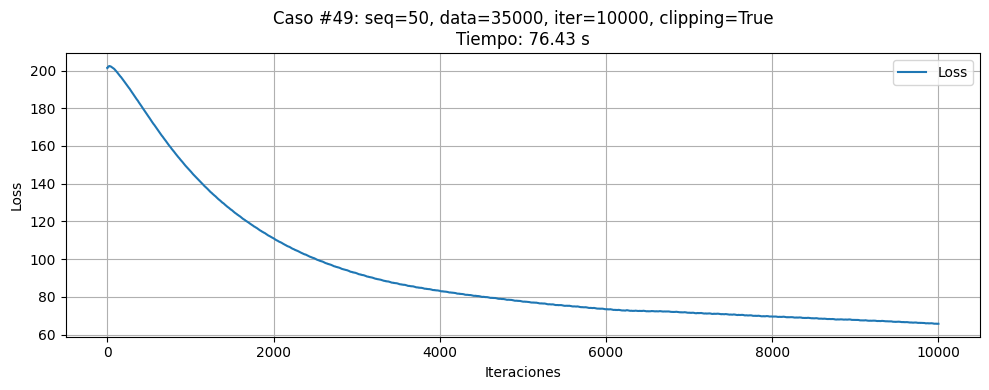


 Caso #50: seq=50, data=35000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


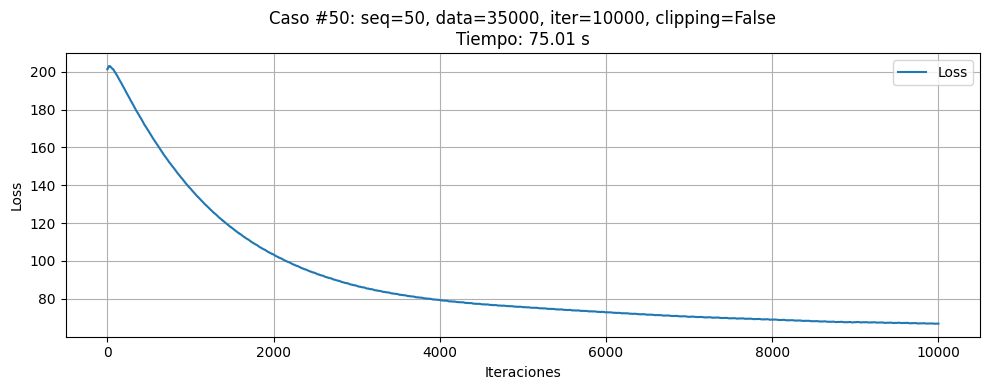


 Caso #51: seq=50, data=35000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


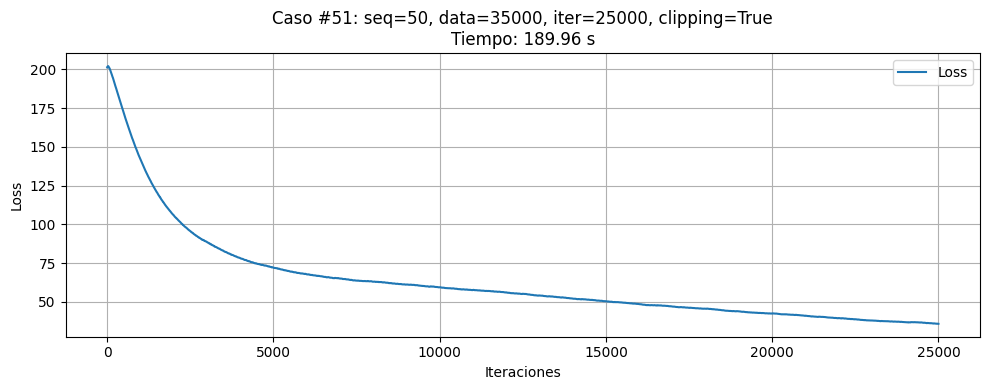


 Caso #52: seq=50, data=35000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


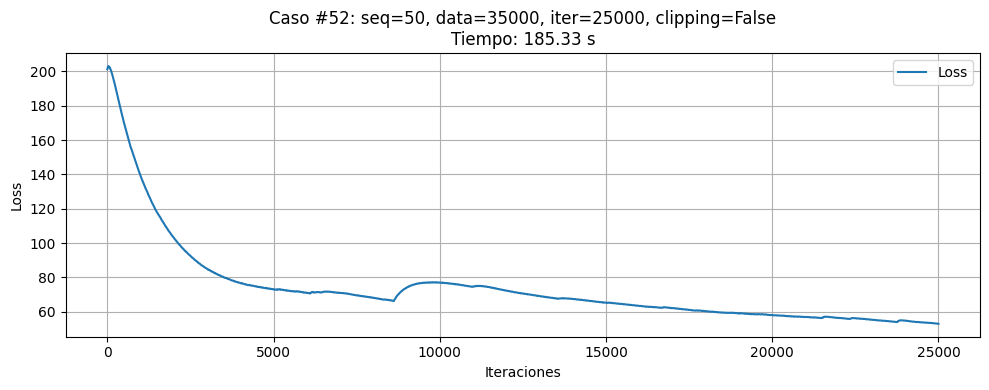


 Caso #53: seq=50, data=35000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


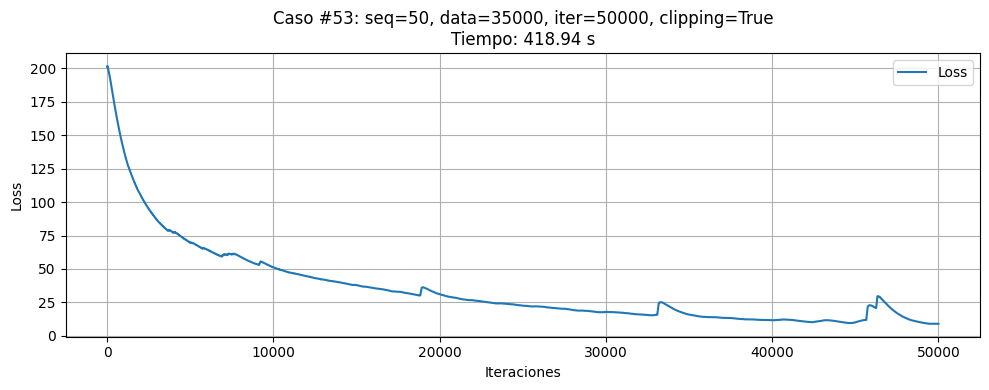


 Caso #54: seq=50, data=35000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


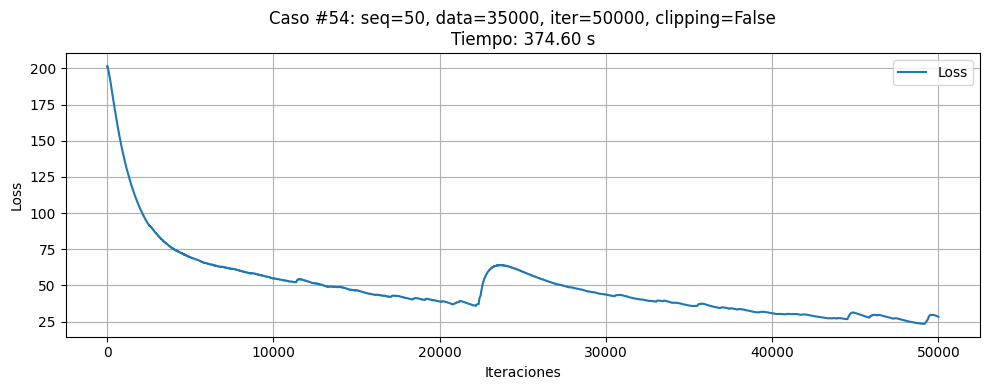

In [ ]:
# Array donde se va a guardar toda la informacion necesaria para el analisis
all_losses = []
all_labels = []
all_generated_names = []
all_final_losses = []

# Ciclo para ejecutar las combinaciones
case_num = 1
for seq_length in seq_lengths:
    for data_size in data_sizes:
        for max_iter in max_iters:
            for gradient_clipping in gradient_clippings:
                label = f"Caso #{case_num}: seq={seq_length}, data={data_size}, iter={max_iter}, clipping={gradient_clipping}"
                print(f"\n {label} ")

                words = words[:data_size]

                # RNN con parámetros actuales
                rnn = vanillaRNN(n_x=vocab_size, n_h=100, seq_length=seq_length, learning_rate=1e-1, gradient_clipping=gradient_clipping)

                # Tiempo de entrenamiento
                start_time = time.time()
                loss_list, sample_char = rnn.train(words, char_to_int, int_to_char, max_iter=max_iter)
                duration = time.time() - start_time

                # Guardar valores de perdida y un ejemplo por cada configuracion
                all_losses.append(loss_list)
                all_labels.append(label)
                all_generated_names.append({
                    "label": label,
                    "name": sample_char
                })
                all_final_losses.append(loss_list[-1])

                # Gráfica individual
                plt.figure(figsize=(10, 4))
                plt.plot(loss_list, label="Loss")
                plt.xlabel("Iteraciones")
                plt.ylabel("Loss")
                plt.title(f"{label}\nTiempo: {duration:.2f} s")
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                plt.show()

                case_num += 1

Ejemplo por cada configuración

In [ ]:
print("Nombres generados por cada configuración")
for i, result in enumerate(all_generated_names):
    print(f"\n{result['label']}\n")
    print(result['name'])

Nombres generados por cada configuración

Caso #1: seq=10, data=5000, iter=10000, clipping=True

ni
Aubly
Alare
Alaninet
Brianca
Adillyn
Branna
AdaerallAndee
Ananyl
Atelniqh
Abbekn
Brey
Any
Ale
Austrie
Agin
Anna
Adey
Adybstel
Adine
Alynatt
Alana
Amkeli
Alaide
Anie
Auna
Bomerle
Ashariia
Apiry
Lrek

Caso #2: seq=10, data=5000, iter=10000, clipping=False

ne
Adiende
Adine
Adiendi
Any
Addie
AdixDiditta
Adelle
Arie
Ada
Ane
Ada
Adaite
Adelon
Adriye
Adia
Ane
Adricadit
Adeynine
Abee
Adisa
Adida
Cale
Adina
Adie
Adeia
Adela
Adica
Anetkea
Andia
Adida
Ada
Adina

Caso #3: seq=10, data=5000, iter=25000, clipping=True

ddie
Aloin
Aalyl
Adre
Agella
Adrie
Avalis
Aillida
Adiane
Adaliaine
Adecia
Anie
Amana
Aeto
Anylle
Agnete
Ailecodina
Adria
Agstine
Aranne
Agatoisti
Adrean
Agait
Alangetta
Athen
Aga
Adrea
Asoria
Annalia


Caso #4: seq=10, data=5000, iter=25000, clipping=False

isel
Anelina
A
Abelile
Aggelea
Agnella
Ainet
Abiela
Alex
Adrai
Aurane
Ader
Alixidra
Aerellena
Ageta
Agata
Abia
Astany
Ariece
Bieli

Configuración con mejores resultados

In [ ]:
# Se usa argmin para encontrar el modelo con menor pérdida final
best_index = np.argmin(all_final_losses)

print(f"{all_labels[best_index]}\n")
print(f"Nombres generados por esta configuracion: \n\n{all_generated_names[best_index]['name']}\n")
print(f"Pérdida final: {all_final_losses[best_index]}")

Caso #5: seq=10, data=5000, iter=50000, clipping=True

Nombres generados por esta configuracion: 

ia
Ainee
Aline
Alena
Alissa
Alisil
AvAlita
Alexina
Alline
Allyn
Allecia
Alyso
Alexine
Allie
Alexia
Alexina
Allyn
Alles
Aliana
Alaina
Allie
Allyna
Alex
Alycaila
Blith
Al
Agalia
Annelle
Alline
Alecia
Al

Pérdida final: 8.706943525214452


# Punto 3

Se toma como referencia el dataset shakespeare.txt disponibles en https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

### Entrenamiento de la RNN usando diferentes valores

Esos valores por los cuales se va a probar la red en cada caso son:

- seq_lengths = [25, 50, 100]
- data_sizes = [5000, 15000, 50000, 110000]
- max_iters = [25000, 10000, 50000]
- gradient_clipping = [True, False]

In [ ]:
# Cargar los datos
with open('shakespeare.txt') as f:
    words = f.read()
    chars = list(set(words))
    words_size, vocab_size = len(words), len(chars)
    char_to_int = {ch:i for i, ch in enumerate(chars)}
    int_to_char = {i:ch for i, ch in enumerate(chars)}

Ejecutar combinaciones


 Caso #1: seq=25, data=5000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


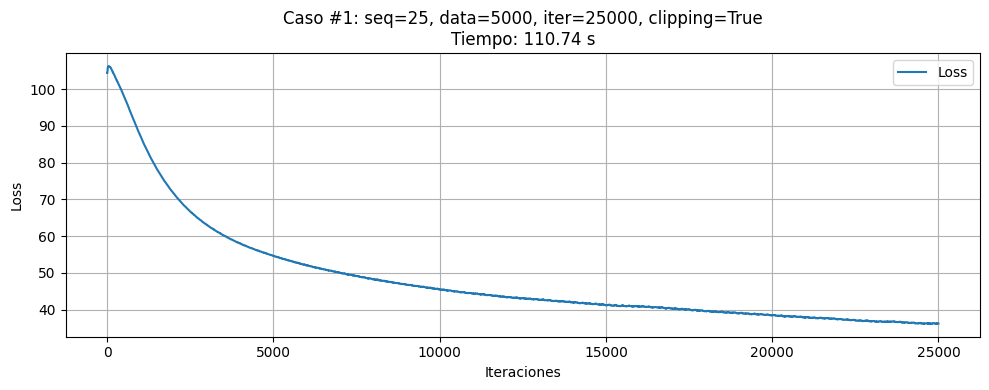


 Caso #2: seq=50, data=5000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


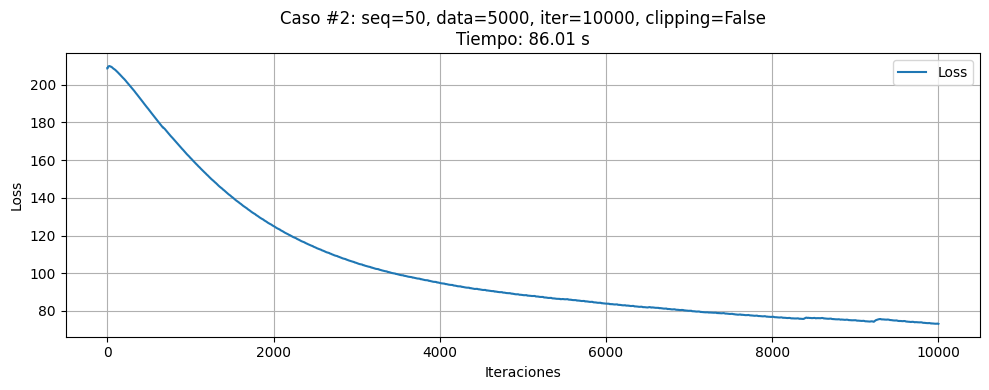


 Caso #3: seq=50, data=15000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


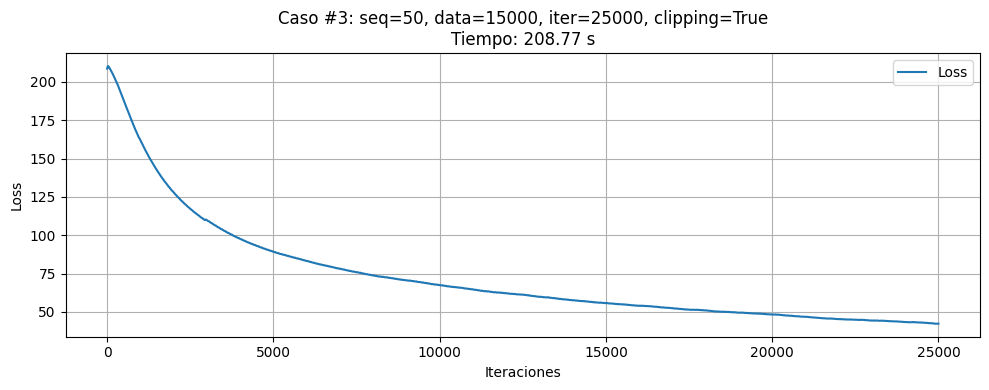


 Caso #4: seq=100, data=5000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


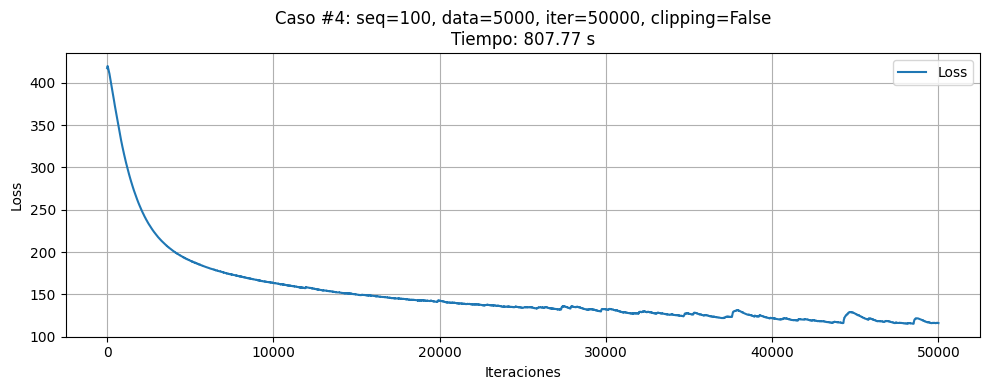


 Caso #5: seq=25, data=15000, iter=10000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


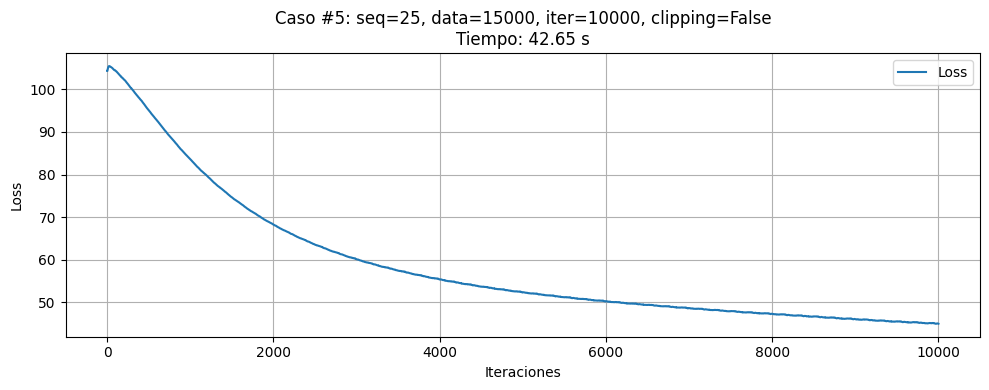


 Caso #6: seq=100, data=15000, iter=25000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


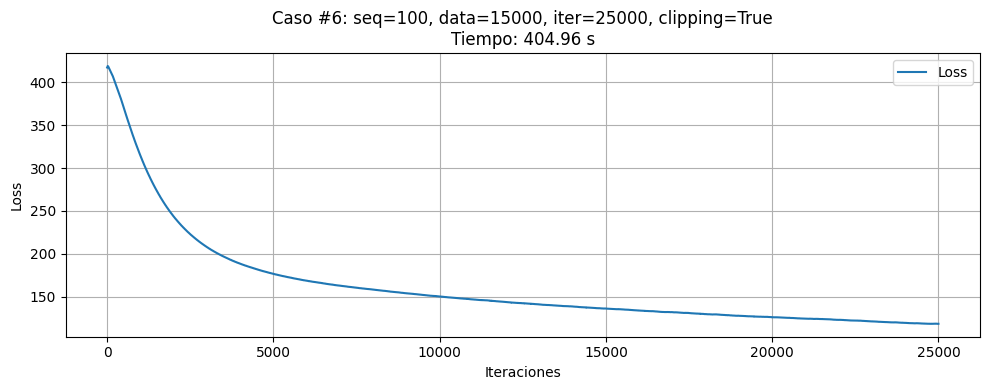


 Caso #7: seq=25, data=50000, iter=50000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


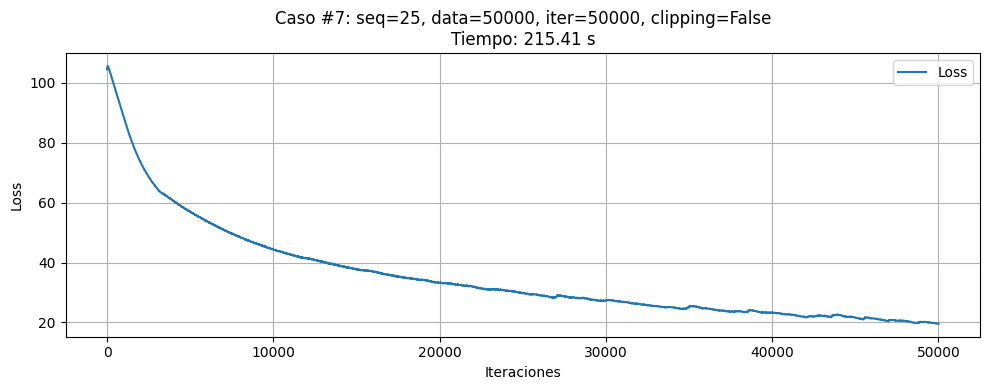


 Caso #8: seq=100, data=50000, iter=10000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


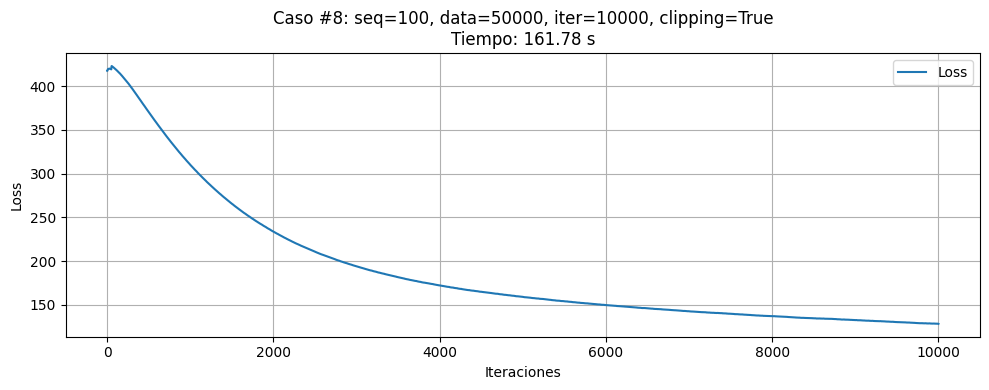


 Caso #9: seq=50, data=110000, iter=25000, clipping=False 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


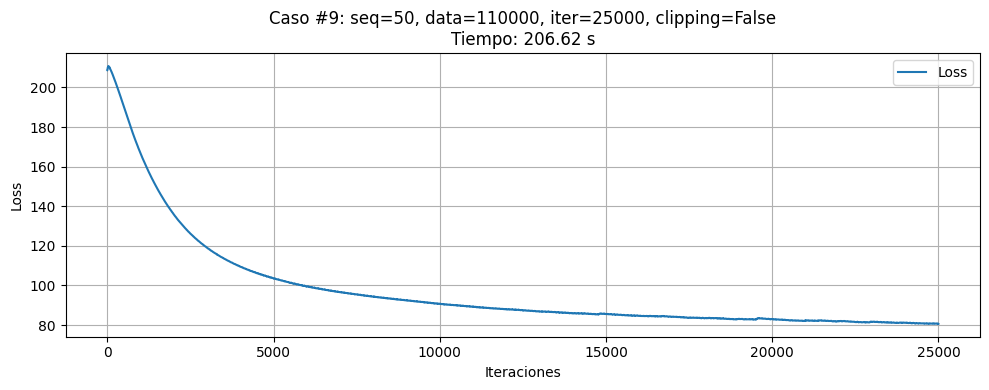


 Caso #10: seq=100, data=110000, iter=50000, clipping=True 
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


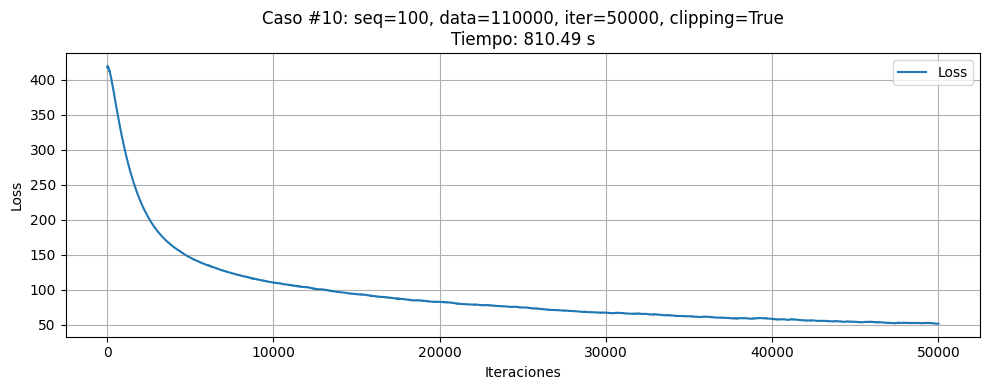

In [ ]:
# Combinaciones a utilizar

combinaciones = [
    (25, 5000, 25000, True),
    (50, 5000, 10000, False),
    (50, 15000, 25000, True),
    (100, 5000, 50000, False),
    (25, 15000, 10000, False),
    (100, 15000, 25000, True),
    (25, 50000, 50000, False),
    (100, 50000, 10000, True),
    (50, 110000, 25000, False),
    (100, 110000, 50000, True)
]

# Array donde se va a guardar toda la informacion necesaria para el analisis

all_losses = []
all_labels = []
all_generated_text = []
all_final_losses = []

case_num = 1
for seq_length, data_size, max_iter, gradient_clipping in combinaciones:
    label = f"Caso #{case_num}: seq={seq_length}, data={data_size}, iter={max_iter}, clipping={gradient_clipping}"
    print(f"\n {label} ")

    words = words[:data_size]

    # RNN con parámetros actuales
    rnn = vanillaRNN(n_x=vocab_size, n_h=100, seq_length=seq_length, learning_rate=1e-1, gradient_clipping=gradient_clipping)

    # Tiempo de entrenamiento
    start_time = time.time()
    loss_list, sample_char = rnn.train(words, char_to_int, int_to_char, max_iter=max_iter)
    duration = time.time() - start_time

    # Guardar valores de pérdida y un ejemplo por cada configuración
    all_losses.append(loss_list)
    all_labels.append(label)
    all_generated_text.append({
        "label": label,
        "text": sample_char
    })
    all_final_losses.append(loss_list[-1])

    # Gráfica individual
    plt.figure(figsize=(10, 4))
    plt.plot(loss_list, label="Loss")
    plt.xlabel("Iteraciones")
    plt.ylabel("Loss")
    plt.title(f"{label}\nTiempo: {duration:.2f} s")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    case_num += 1

Ejemplo por cada configuración

In [ ]:
print("Textos generados por cada configuración")
for i, result in enumerate(all_generated_text):
    print(f"\n{result['label']}\n")
    print(result['text'])

Textos generados por cada configuración

Caso #1: seq=25, data=5000, iter=25000, clipping=True

d. Caked hors, you he. the in thuas,, mutt? chat onth, sole cuak, dims, cuthacrticn walves fouded, therf fond annthe dearser peit- uV, bour
tous aron
tt to thacuit has dous--
For
than
Tering cas grie 

Caso #2: seq=50, data=5000, iter=10000, clipping=False

mielny faect; the lian ciy wable souse foo manicibendind it Citizen:
Yourss
Asmacus, I matind to the mamamisery will: wis thate-is, be mDits mto kenitr pases.

First Citizen:
Befenther wFinge
Theciste

Caso #3: seq=50, data=15000, iter=25000, clipping=True

 in the lomy the thamswe pacefatrow Canag them ainst the and to proid eavld way colm the lay, wht aiplay n mestende payocl coutsten:: selptange; fave yotre his.

MENENIUS:
Eipceor
Un
Fimitizeng! sur a

Caso #4: seq=100, data=5000, iter=50000, clipping=False

ay re't, rise instrar memich not ungsoy. If the bectitirebstid, suset; my.

First Citizen:
He's alty fafly be repeare-u gooy prim

Configuración con mejores resultados

In [ ]:
# Se usa argmin para encontrar el modelo con menor pérdida final
best_index = np.argmin(all_final_losses)

print(f"{all_labels[best_index]}\n")
print(f"Texto generado por esta configuración: \n\n{all_generated_text[best_index]['text']}\n")
print(f"Pérdida final: {all_final_losses[best_index]}")

Caso #7: seq=25, data=50000, iter=50000, clipping=False

Texto generado por esta configuración: 

 suimm,
The hesmmenard?

Aliow we he's? The bebtars, be con, I shys northir the gour n't on belly and ugainst we keles: to fllble poor
MMfold beed of welll your.

Sece goo hale;
And in is recoust fabe

Pérdida final: 19.57269246502551
